In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns
import geo
import os
import avwx.tds
from mpl_toolkits.basemap import Basemap
import warnings; warnings.simplefilter('ignore')
import networkx as nx
%matplotlib inline

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style"))

In [3]:
def divide_chunks(l, n): 
    return [l[i:i+n] for i in range(0, len(l), n)]
        
def get_metars(stations, batch_size=500, cache=None):
    if cache is not None and os.path.exists(cache):
        return pd.read_pickle(cache)
    
    metars = {}
    for batch in divide_chunks(stations, 500):
        data = avwx.tds.get_latest_metar(batch)
        metars.update(data)
        # get all the metars
    metar_table = pd.DataFrame(metars.values())
    metar_table = metar_table.drop(columns=['raw_xml'])
    front_cols = ['station_id', 'observation_time']
    metar_table = metar_table.reindex(columns=front_cols + [c for c in metar_table.columns.tolist() if c not in front_cols])
    if cache is not None:
        metar_table.to_pickle(cache)
    return metar_table

In [4]:
def load_towers():
    import struct
    s = struct.Struct("4x 4s 1s 1s 1s 1s 300s 1296x")
    with open('data/NASR/TWR.txt', 'rb') as f:
        towers = pd.DataFrame([[y.decode().strip() for y in s.unpack_from(x)] for x in f if x.startswith(b"TWR8")])
        towers.columns = ['faa_id', 'bravo', 'charlie', 'delta', 'echo', 'hours']
        towers = towers.sort_values(by='faa_id')
        for cls in ['bravo', 'charlie', 'delta', 'echo']:
            towers[cls] = towers[cls] == 'Y'
    return towers

In [5]:
def dms_to_dec(dms):
    """
    Convert degrees-minutes-seconds to decimal.
    dms_to_dec("41-04-01.0299N") -> 41.066952750000006
    dms_to_dec("073-42-27.2396W")-> -73.70756655555556
    """
    direction = dms[-1]
    deg, minutes, seconds = map(float, dms[:len(dms)-1].split("-"))
    dec = deg + minutes/60 + seconds/3600
    if direction in ('W', 'S'):
        dec = dec * -1
    return dec

# Collect Data

In [6]:
towers = load_towers()
conn = sqlite3.connect("data/nasr.db")
airports = pd.read_sql_query("SELECT apt.icao_id as station_id, apt.faa_id as faa_id, apt.latitude_dms, apt.longitude_dms, apt.name, apt.city, apt.state_code, apt.state_name, CAST(AVG(rwy.length) as INT) as mean, COUNT(*) as count, MAX(rwy.length) as max, MIN(rwy.length) as min FROM runways rwy LEFT JOIN airports apt ON rwy.facility_site_number = apt.facility_site_number wHERE apt.facility_type='AIRPORT' AND apt.facility_use='PU' AND rwy.name not like 'H%' AND apt.icao_id IS NOT NULL GROUP BY apt.icao_id  ORDER BY MEAN", conn)

# convert airports latitude and longitude into decimals
for degc, dmsc in [('latitude', 'latitude_dms'), ('longitude', 'longitude_dms')]:
    airports[degc] = airports[dmsc].apply(dms_to_dec)

In [7]:
metars = get_metars(airports['station_id'], cache='data/metars.pkl')
# Remove coordinates from metar data, will use FAA data instead
metars = metars[[x for x in metars.columns if x not in ('latitude', 'longitude')]]

# Exclude Airports

In [8]:
include_airports = ['MYNN', 'MYGF']
# Exclude Guam
exclude_airports = ['TNI', 'GUM']
# Exclude Puerto Rico
exclude_airports.extend(['SIG', 'SJU', 'BQN', 'CPX', 'ABO', 'VQS', 'MAZ', 'PSE', 'RVR'])
# Exclude Micronesia, Mariana Islands
exclude_airports.extend(['TTK', 'T11', 'TKK', 'PNI', 'GRO', 'ROR', 'GSN', 'MAJ', ])
# Exclude American Somoa
exclude_airports.extend(['Z08', 'FAQ', 'PPG'])
# Exclude Virgin Islands
exclude_airports.extend(['STT', 'STX', 'TUPJ'])
# Exclude Aruba, Saint Martin, Anguilla
exclude_airports.extend(['TNCE', 'TNCM', 'TFFG', 'TQPF'])
# Exclude Canada, Bermuda 
exclude_airports.extend(['CYSU', 'CYSJ', 'CYSL', 'TXKF'])
# Exclude airports without a state code
exclude_airports.extend(airports[airports['state_code'].isna()]['faa_id'])
# Exclude Hawaii, Alaska, and Midway
exclude_airports.extend(airports[airports['state_code'].isin(['HI', 'AK','MQ'])]['faa_id'])
airports['excluded'] = airports['faa_id'].isin(exclude_airports)
airports['excluded'] = airports['excluded'] & ~airports['faa_id'].isin(include_airports)
# Remove excluded airports
airports = airports[~airports['excluded']]

In [9]:
len(airports)

2129

# Merge Data

In [10]:
data = pd.merge(airports, metars, on='station_id', how='left')
data = pd.merge(data, towers, on='faa_id', how='left')
data = data.fillna(value={'bravo': False, 'charlie': False, 'delta': False, 'echo': False})
data['elevation_ft'] = data['elevation_m'] * 3.281
data['airspace'] = data.apply(lambda x: 'B' if x['bravo'] else 'C' if x['charlie'] else 'D' if x['delta'] else 'E' if x['echo'] else 'G', axis=1)
data = data.set_index(data['station_id'])
state_long = data.groupby('state_code')[['longitude', 'latitude']].min().rename(columns={'longitude': 'min_longitude', 'latitude': 'min_latitude'})
data = data.join(state_long, on='state_code', how='left')

In [11]:
nometars = data[data['observation_time'].isna()]
# Exclude data without metar information
data = data[~data['observation_time'].isna()]

In [12]:
len(data)

1754

# Runway Length Distribution

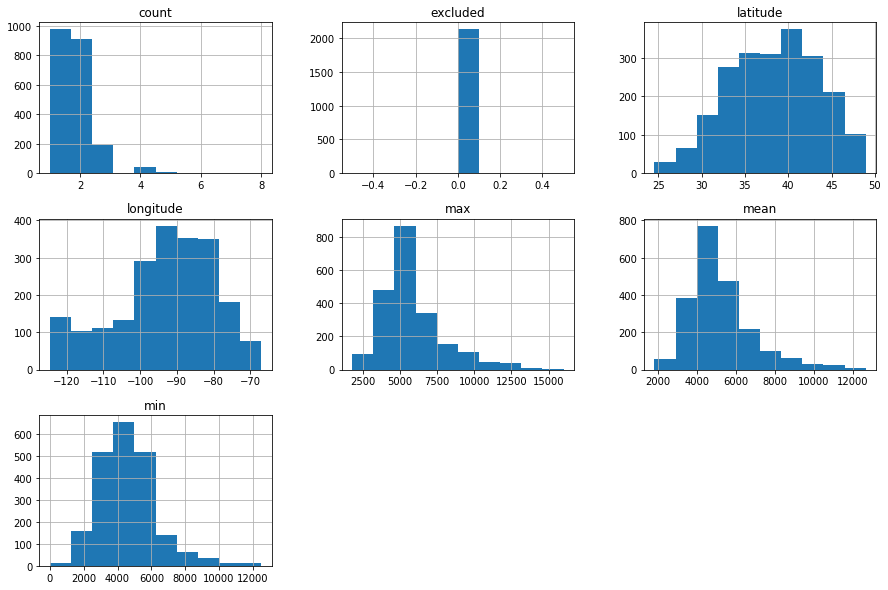

In [13]:
airports.hist(figsize=(15, 10));

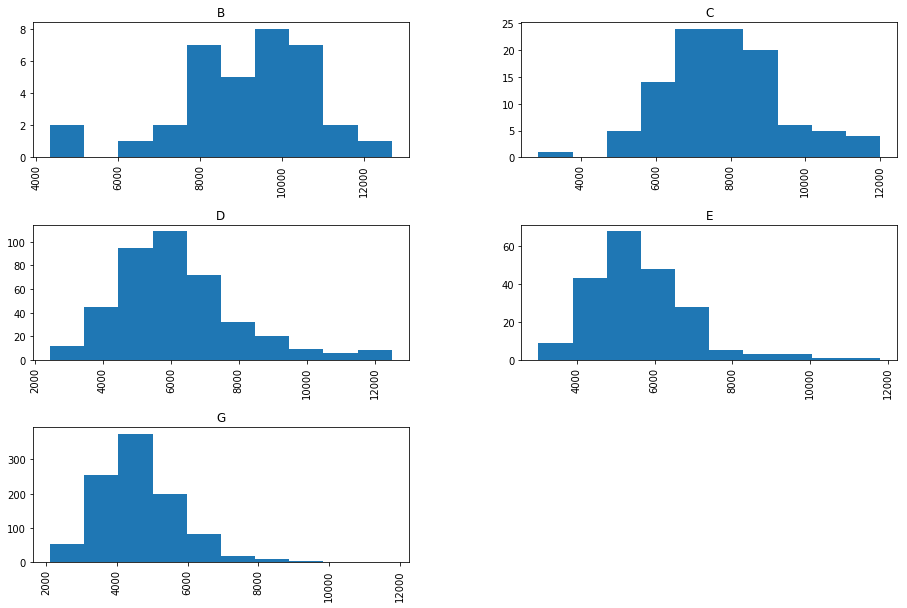

In [14]:
data['mean'].hist(by=data['airspace'], figsize=(15,10));

# Various Charts

In [ ]:
plt.figure(figsize=(15, 10))
axes = sns.regplot(x='latitude', y='mean', data=data)
axes.set_title("Average Airport Runway Length By Latitude")
axes.set_xlabel("Latitude")
axes.set_ylabel("Average Runway Length (feet)")
axes.get_figure().text(0.05, 0.05, "Data sources: FAA", fontsize=12);

In [ ]:
#data.plot.scatter(x='longitude', y='mean', figsize=(15, 10));
plt.figure(figsize=(15, 10))
axes = sns.regplot(x='longitude', y='mean', data=data[(data['longitude'] >= -125) &
                                                      (data['longitude'] <= -65)]);
axes.set_title("Average Lower-48 Airport Runway Length By Longitude")
axes.set_xlabel("Longitude")
axes.set_ylabel("Average Runway Length (feet)")
axes.get_figure().text(0.05, 0.05, "Data sources: FAA", fontsize=12);

In [ ]:
plt.figure(figsize=(15, 10))
axes = sns.regplot(x='elevation_ft', y='mean', data=data, robust=True)
axes.set_title("Average Airport Runway Length By Field Elevation")
axes.set_xlabel("Field Elevation (feet)")
axes.set_ylabel("Average Runway Length (feet)")
axes.get_figure().text(0.05, 0.05, "Data sources: FAA, NOAA", fontsize=12);

# Maps

In [16]:
def airport_map_plot(data, title="United States (Lower 48) Public Use Airports", hue='airspace', palette=None):
    plt.figure(figsize=(25, 18))
    axes = sns.scatterplot(x='longitude', y='latitude', data=data, hue=hue, palette=palette)
    axes.set_title(title, fontsize=20)
    axes.set_xlabel("Longitude")
    axes.set_ylabel("Latitude")
    axes.get_figure().text(0.05, 0.05, "Data sources: FAA", fontsize=12);
    return axes

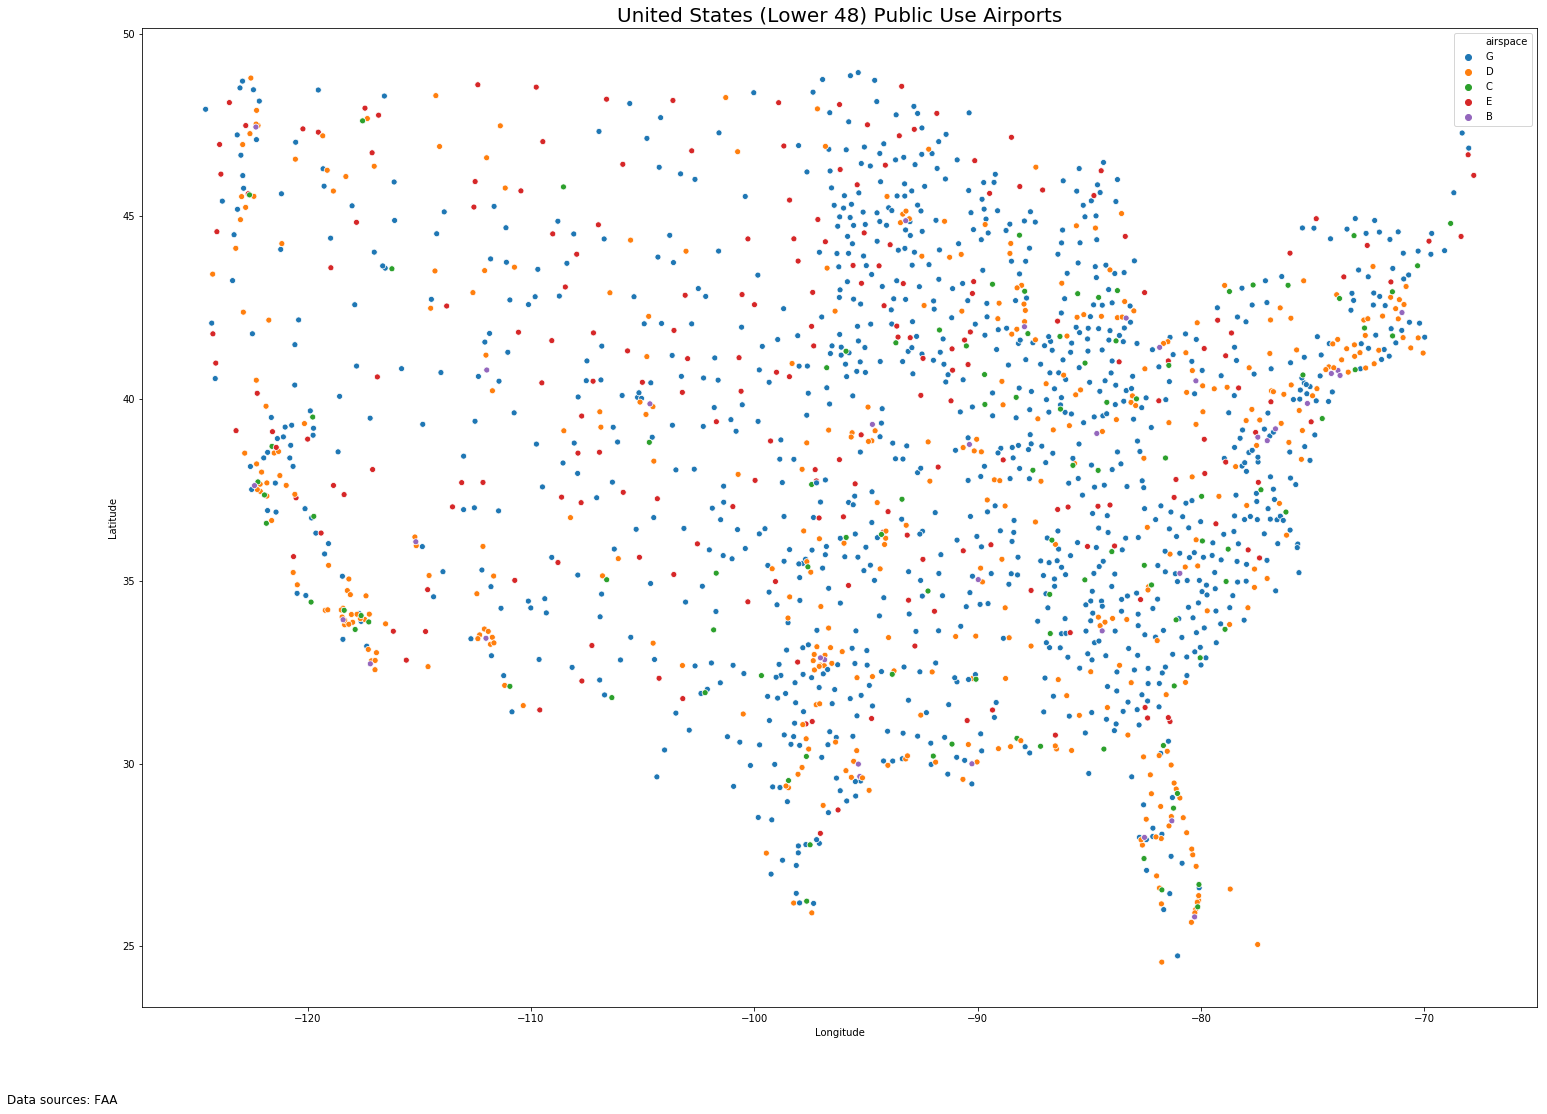

In [17]:
airport_map_plot(data);

# Picking a Subset of Airports

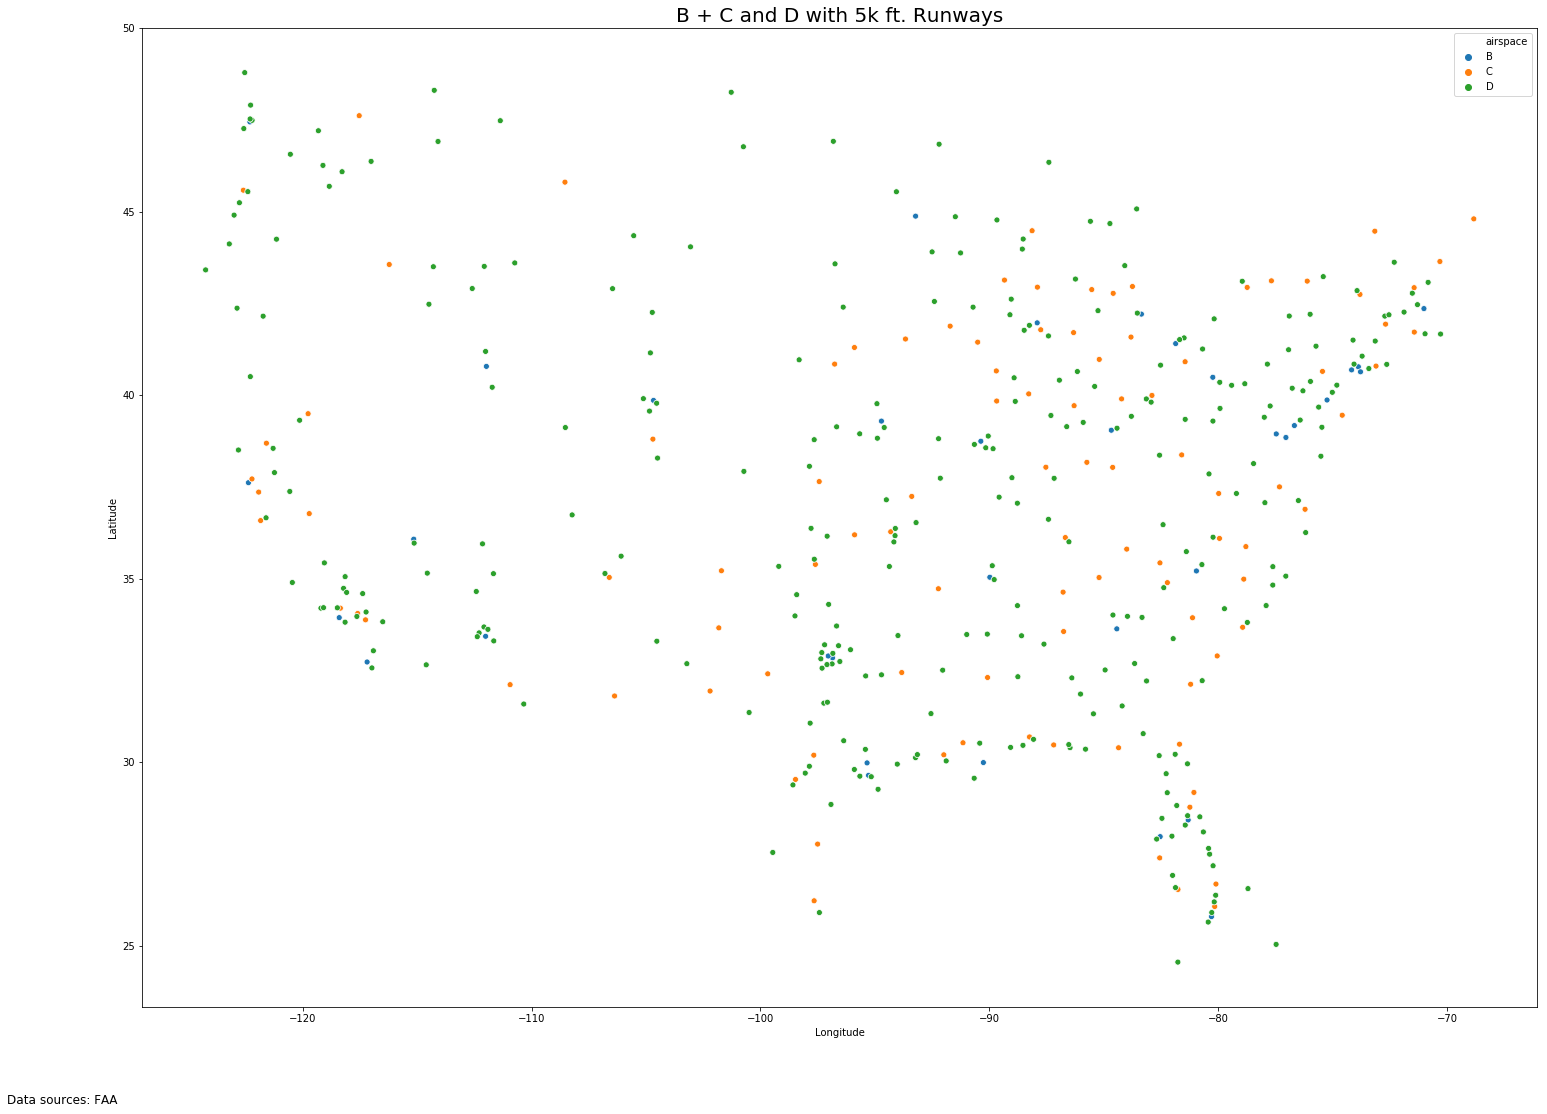

In [18]:
class_b = data[data['airspace'] == 'B']
class_c_long = data[(data['airspace'] == 'C') & (data['mean'] >= 5000)]
class_d_long = data[(data['airspace'] == 'D') & (data['mean'] >= 5000)]
data_subset = pd.concat([class_b, class_c_long, class_d_long])
airport_map_plot(data_subset, title="B + C and D with 5k ft. Runways");

# Chosen Airports by State

In [ ]:
data_subset.groupby('state_code')[['mean']].count().reset_index().sort_values(by='mean', ascending=False).plot.bar(x='state_code', y='mean', figsize=(20,15), title="Number of Airports (All Bravo, Charlie & Delta with 5000 ft. Runways) by State.")

# Clustering The Airports

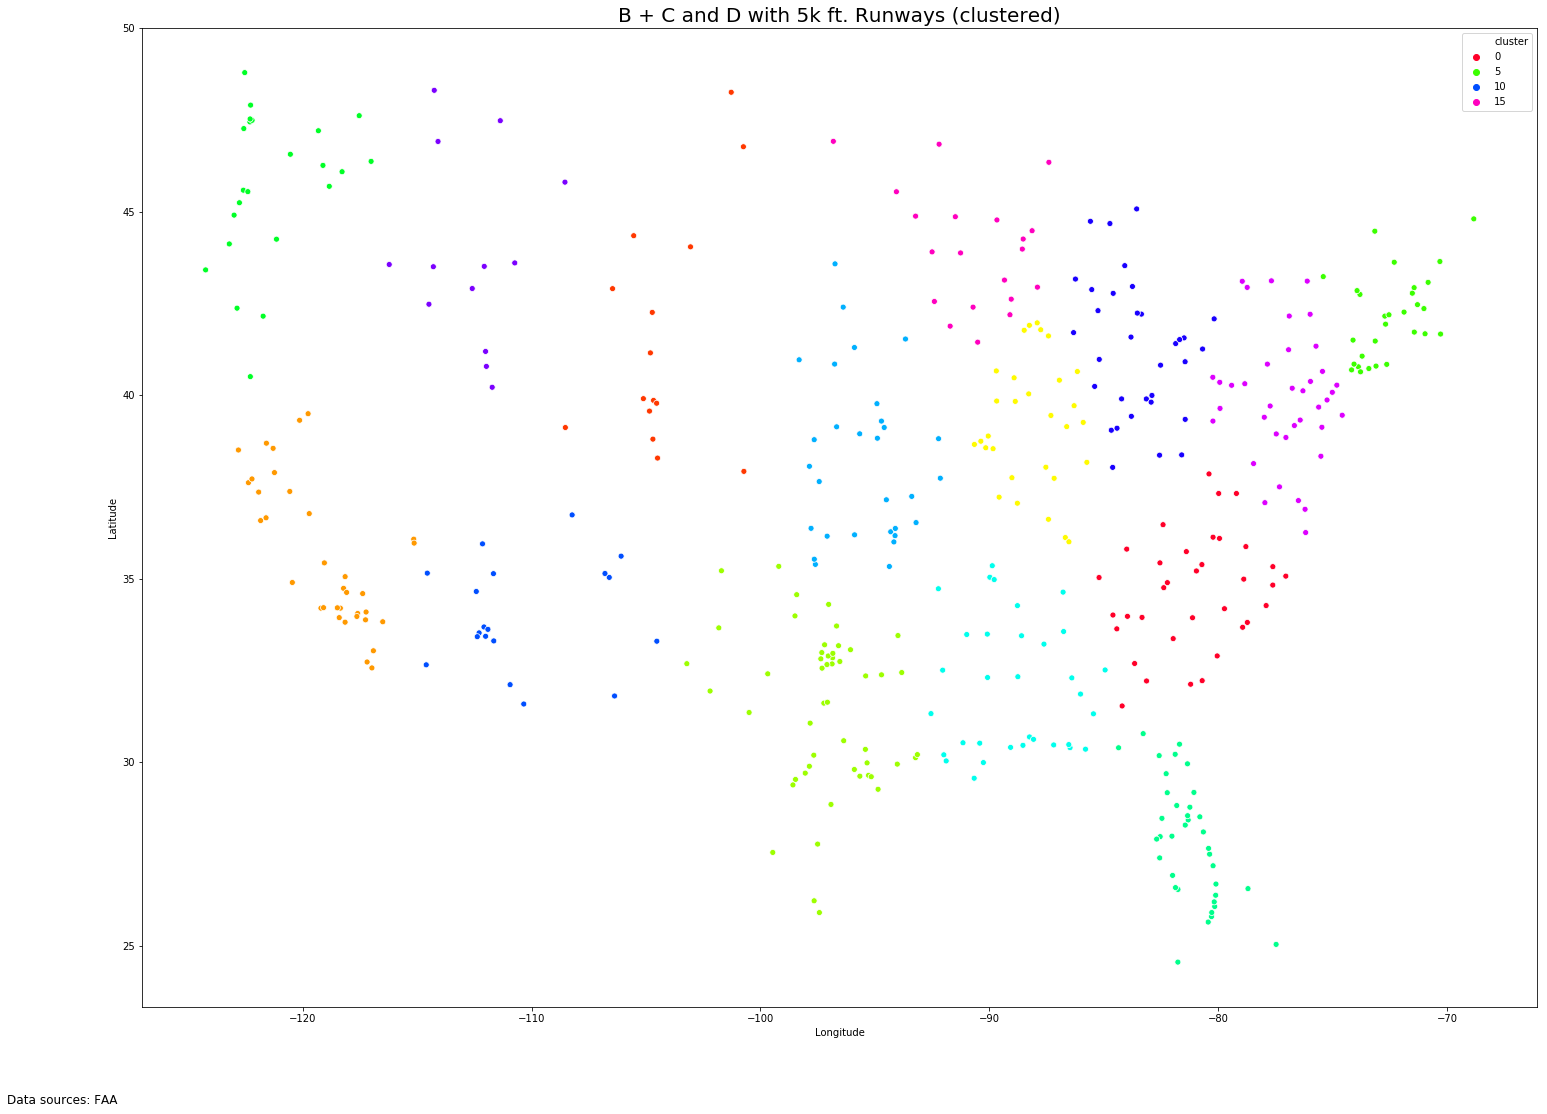

In [45]:
from sklearn.cluster import KMeans

#bravos = data_subset[data_subset['airspace'] == 'B']
#km = KMeans(n_clusters=len(bravos), init=bravos[['longitude', 'latitude']].values, n_init=1)
km = KMeans(n_clusters=15)

km.fit(data_subset[['longitude', 'latitude']].values)
data_subset['cluster'] = km.labels_
airport_map_plot(data_subset, title="B + C and D with 5k ft. Runways (clustered)", hue="cluster", palette='gist_rainbow');

# Build Airport Graph

In [ ]:
import networkx as nx
G = nx.Graph()
G.add_nodes_from(data_subset['station_id'])

distances = {}

for x in data_subset['station_id']:
    for y in data_subset['station_id']:
        if (x,y) in distances:
            dist = distances[(x, y)]
        elif (y,x) in distances:
            dist = distances[(y, x)]
        else:
            a = data_subset.loc[x]
            b = data_subset.loc[y]
            dist = geo.haversine(a['longitude'], a['latitude'], b['longitude'], b['latitude'], miles=True)
            distances[(x,y)] = dist

        if (dist >= 20) and (dist <= 175):
            G.add_edge(x, y)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(60, 60));
nx.draw_networkx(G, ax=ax)

In [ ]:
data_subset['neighbors'] = data_subset['station_id'].apply(lambda x:len(list(G.neighbors(x))))

In [ ]:
printout = data_subset.sort_values(by=['min_longitude', 'min_latitude', 'state_code', 'longitude','latitude'])[['faa_id','name', 'state_code', 'state_name', 'longitude_dms', 'latitude_dms', 'airspace','neighbors']]
printout.to_excel('data/printout.xls')

In [41]:
def midpoint(x1, y1, x2, y2):
    import math
    #Input values as degrees

    #Convert to radians
    lat1 = math.radians(y1)
    lon1 = math.radians(x1)
    lat2 = math.radians(y2)
    lon2 = math.radians(x2)


    bx = math.cos(lat2) * math.cos(lon2 - lon1)
    by = math.cos(lat2) * math.sin(lon2 - lon1)
    lat3 = math.atan2(math.sin(lat1) + math.sin(lat2), \
           math.sqrt((math.cos(lat1) + bx) * (math.cos(lat1) \
           + bx) + by**2))
    lon3 = lon1 + math.atan2(by, math.cos(lat1) + bx)

    return [round(math.degrees(lon3), 2), round(math.degrees(lat3), 2)]


In [42]:
def distance(a, b, data=data):
    lona, lata = (data.loc[a]['longitude'], data.loc[a]['latitude'])
    lonb, latb = (data.loc[b]['longitude'], data.loc[b]['latitude'])
    distance = geo.haversine(lona, lata, lonb, latb, miles=True)
    return distance

In [43]:
def build_map(data, chosen_airports, lines=True, warn=180):
    
    missing_airports = [x for x in chosen_airports if x not in list(data['faa_id'])]

    if len(missing_airports) > 0:
        print("ERROR: Missing data for: {}".format(missing_airports))
        return
        
    df = data[data['faa_id'].isin(chosen_airports)]
    df.index=df['faa_id']
    df = df.loc[chosen_airports]
    print("There are {} airports on the map".format(len(df)))
    plt.figure(figsize=(30,20))
    #m = Basemap(width=5000000,height=4000000,
    #    projection='lcc', resolution='l',lat_1=45.,lat_2=55,lat_0=40,lon_0=-97.)
    m = Basemap(width=5000000,height=3500000,
        projection='lcc', resolution='l',lat_1=45.,lat_2=55,lat_0=40,lon_0=-97.)
    #m.shadedrelief()
    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()

    x, y = m(
        list(df['longitude']),
        list(df['latitude']))
    
    airspace_colors = {'B':'blue', 'D':'red', 'C':'magenta', 'E':'green', 'G': 'black'}
    
    m.scatter(x,y, marker='o', c=df['airspace'].apply(lambda x:airspace_colors[x]), s=30)
    
    for i in range(len(df) - 1):
        point_a = df.iloc[i]
        point_b = df.iloc[i+1]
        nylon = point_a['longitude']
        nylat = point_a['latitude']
        lonlon = point_b['longitude']
        lonlat = point_b['latitude']
        
        distance = int(geo.haversine(nylon, nylat, lonlon, lonlat, miles=True))
        mid = midpoint(nylon, nylat, lonlon, lonlat)
        mid_x, mid_y = m(*mid)
        color = 'red' if distance > warn else 'black'
        if lines:
            m.drawgreatcircle(nylon,nylat,lonlon,lonlat,linewidth=1,color=color)
            plt.text(mid_x, mid_y, str(distance), fontsize=10, ha='left', va='bottom', color=color)
        
    
    for i in range(len(df)):
        place = df.iloc[i]
        lon = x[i]
        lat = y[i]
        ident = place['faa_id']
        plt.text(lon, lat, ident, fontsize=12,fontweight='bold',
                    ha='left',va='bottom',color='black')
    plt.show()

In [ ]:
chosen_airports = [
    'SAN',
    'NYL',
    'PHX',
    'TUS',
    'DMN',
    'ELP',
    'ROW',
    'ABQ',
    'FMN',
    'ASE',
    'CYS',
    'DEN',
    'GLD',
    'HQG',
    'AMA',
    'LBB',
    'MAF',
    'FST',
    'SJT',
    'DRT',
    'LRD',
    'CRP',
    'AUS',
    'IAH',
    'LCH',
    'SHV',
    'LIT',
    'MLU',
    'LFT',
    'MSY',
    'GPT',
    'JAN',
    'GWO',
    'MEM',
    'PAH',
    'STL',
    'BMI',
    'IND',
    'LEX',
    'BNA',
    'BHM',
    'MGM',
    'PNS',
    'ECP',
    'TLH',
    'OCF',
    'TPA',
    'FMY',
    'EYW',
    'MIA',
    'MYNN',
    'MYGF',
    'PBI',
    'MCO',
    'JAX',
    'ABY',
    'ATL',
    'CHA',
    'TYS',
    'CLT',
    'AGS',
    'SAV',
    'CHS',
    'MYR',
    'EWN',
    'RDU',
    'ORF',
    'IAD',
    'DOV',
    'PHL',
    'EWR',
    'JFK',
    'HPN',
    'ISP',
    'GON',
    'HFD',
    'MVY',
    'BOS',
    'PWM',
    'BGR',
    'LEB',
    'BTV',
    'ALB',
    'SWF',
    'AVP',
    'SYR',
    'BUF',
    'UNV',
    'PIT',
    'CKB',
    'ROA',
    'CRW',
    'CVG',
    'CMH',
    'CLE',
    'DTW',
    'MKG',
    'ORD',
    'GRB',
    'EAU',
    'DLH',
    'MSP',
    'CMY',
    'MLI',
    'DSM',
    'MCI',
    'SGF',
    'FYV',
    'TXK',
    'DFW',
    'OKC',
    'TUL',
    'ICT',
    'SLN',
    'GRI',
    'OMA',
    'FSD',
    'MOX',
    'FAR',
    'GFK',
    'MOT',
    'BWW',
    'RAP',
    'GCC',
    'BIL',
    'HLN',
    'GPI',
    'GEG',
    'YKM',
    'SEA',
    'PDX',
    'EUG',
    'MFR',
    'RDD',
    'SAC',
    'SFO',
    'FAT',
    'SBP',
    'LAX',
    'PSP',
    'LAS',
    'GCN',
    'MLF',
    'SLC',
    'AFO', 
    'TWF',
    'BOI',
    'GCD',
    'LKV',
    'RNO'
]

In [37]:
chosen_airports2 = [
    'SAN',
    'NYL',
    'PHX',
    'TUS',
    'DMN',
    'ELP',
    'ROW',
    'ABQ',
    'FMN',
    'ASE',
    'CYS',
    'DEN',
    'GLD',
    'HQG',
    'AMA',
    'LBB',
    'MAF',
    'FST',
    'SJT',
    'DRT',
    'LRD',
    'CRP',
    'AUS',
    'IAH',
    'LCH',
    'SHV',
    'LIT',
    'MLU',
    'LFT',
    'MSY',
    'GPT',
    'JAN',
    'GWO',
    'MEM',
    'PAH',
    'STL',
    'BMI',
    'IND',
    'LEX',
    'BNA',
    'BHM',
    'MGM',
    'PNS',
    'ECP',
    'TLH',
    'OCF',
    'TPA',
    'FMY',
    'EYW',
    'MIA',
    'MYNN',
    'MYGF',
    'PBI',
    'MCO',
    'JAX',
    'ABY',
    'ATL',
    'CHA',
    'TYS',
    'CLT',
    'AGS',
    'SAV',
    'CHS',
    'MYR',
    'EWN',
    'RDU',
    'ORF',
    'IAD',
    'DOV',
    'PHL',
    'EWR',
    'JFK',
    'HPN',
    'ISP',
    'GON',
    'HFD',
    'MVY',
    'BOS',
    'PWM',
    'BGR',
    'LEB',
    'BTV',
    'ALB',
    'SWF',
    'AVP',
    'SYR',
    'BUF',
    'UNV',
    'PIT',
    'CKB',
    'ROA',
    'CRW',
    'CVG',
    'CMH',
    'CLE',
    'DTW',
    'MKG',
    'ORD',
    'GRB',
    'EAU',
    'DLH',
    'MSP',
    'CMY',
    'MLI',
    'DSM',
    'MCI',
    'SGF',
    'FYV',
    'TXK',
    'DFW',
    'OKC',
    'TUL',
    'ICT',
    'SLN',
    'GRI',
    'OMA',
    'FSD',
    'MOX',
    'FAR',
    'GFK',
    'MOT',
    'BWW',
    'RAP',
    'GCC',
    'BIL',
    'HLN',
    'GPI',
    'GEG',
    'YKM',
    'SEA',
    'PDX',
    'EUG',
    'MFR',
    'RDD',
    'SAC',
    'SFO',
    'FAT',
    'SBP',
    'LAX',
    'PSP',
    'LAS',
    'GCN',
    'MLF',
    'SLC',
    'PIH',
    'JAC', 
    'SUN',
    'TWF',
    'BAM',
    
    'RNO'
]

In [29]:
data.index = data['faa_id']
sum([distance(data.loc[chosen_airports2[i]]['faa_id'], data.loc[chosen_airports2[i+1]]['faa_id'], data=data) for i in range(len(chosen_airports2) - 1)])

19500.851266418267

In [ ]:
for i, code in enumerate(chosen_airports2):
    print ("{0: <4}{1}".format(i, code))

In [ ]:
sacrifices = ['DUG', 'SAT', 'GTR', 'GLH', 'EVV', 'EKX', 'MOB', 'VRB', 'DAB', 'VLD', 'CTJ', 'AVL', 'RIC', 'ABE', 'DXR', 'HTO', 'CEF', 'ACK', 'MHT', 'ROC', 
              'MRB', 'HTS', 'SPS', 'WDG', 'MRY', 'IFP', 'WMC', 'MCN', 'ELM', 'CAE', 'LAN', 'SBN', 'SDF', 'DHN', 'PVD', 'ACY', 'DVL', 'BHB', 'IWD', 'BML',
              'ART', 'SAW', 'PQI', 'CAO', 'TMT', 'DMN', 'BFF', 'ERI', 'MLS', 'CPR', 'GOV', 'GCK']

In [ ]:
# missing bravos
data[data['bravo']]['faa_id'][~data[data['bravo']]['faa_id'].isin(chosen_airports)]

In [ ]:
[x for x in sacrifices if x in chosen_airports]

In [ ]:
build_map(data, chosen_airports, lines=True, warn=191);

There are 150 airports on the map


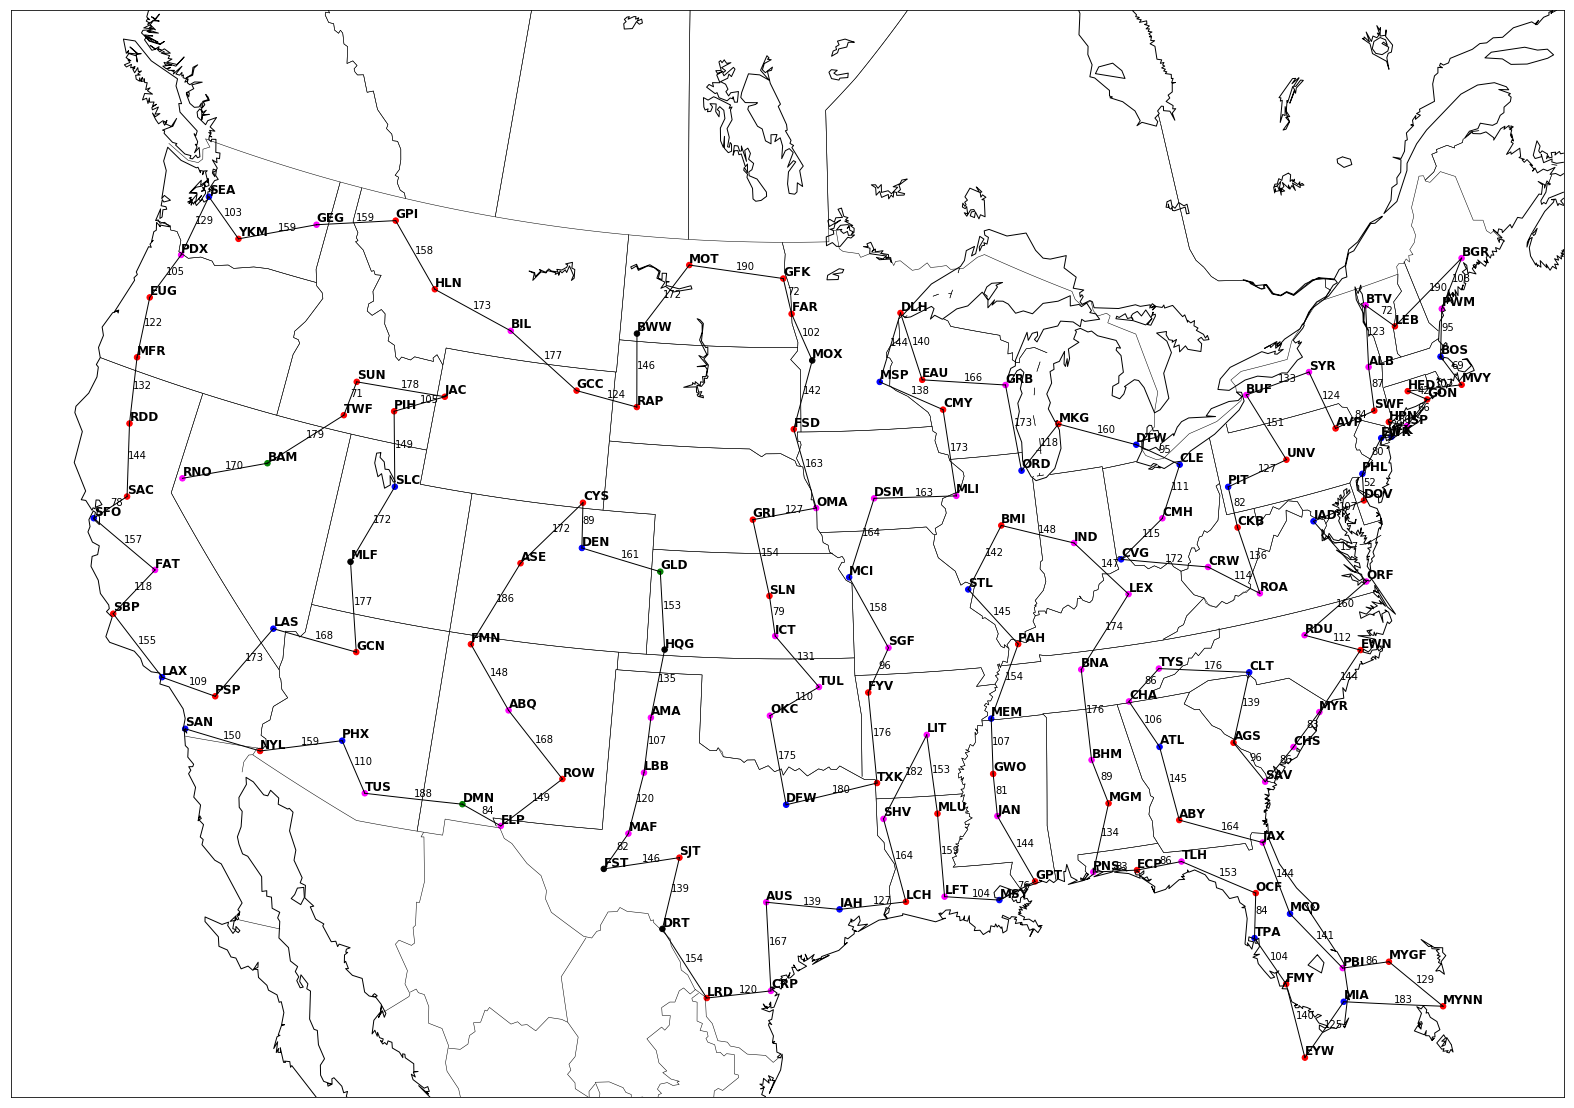

In [44]:
build_map(data, chosen_airports2, lines=True, warn=191);

In [ ]:
distance('KBOI', 'KRNO')

# Shortest Path

In [ ]:
# build distance_matrix
def build_distance_matrix(data, faa_ids):
    df = data[data['faa_id'].isin(faa_ids)][['faa_id', 'longitude', 'latitude']]
    df.index = df['faa_id']
    matrix = [[distance(x, y, data=df) for y in faa_ids] for x in faa_ids]
    matrix = pd.DataFrame(matrix, columns=faa_ids, index=faa_ids)
    return matrix

In [ ]:
distance_matrix = build_distance_matrix(data, chosen_airports)

In [ ]:
def build_graph(faa_ids, distance_matrix):
    graph = nx.Graph()
    graph.add_nodes_from(faa_ids)
    edges = []
    
    for x in faa_ids:
        for y in faa_ids:
            if (x != y) and ((x, y) not in edges) and ((y, x) not in edges):
                graph.add_edge(x, y, weight=dist)
                dist = distance_matrix[x][y]
                edges.append((x, y))

    return graph

In [ ]:
graph = build_graph(chosen_airports, distance_matrix)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(30, 30));
nx.draw_networkx(graph, ax=ax)

In [31]:
import dwave_networkx as dnx
import dimod
import neal
from dwave_networkx.algorithms.tsp import traveling_salesperson
#path = traveling_salesperson(graph, dimod.ExactSolver(), weight='weight', lagrange=2)
path = traveling_salesperson(graph, neal.SimulatedAnnealingSampler(), weight='weight', lagrange=1200)

ModuleNotFoundError: No module named 'dwave_networkx'

In [ ]:
path

In [ ]:
build_map(data, path, lines=True);

In [ ]:
len(path)

In [ ]:
G = nx.complete_graph(4)
G.add_weighted_edges_from({(0, 1, 1), (0, 2, 2), (0, 3, 3), (1, 2, 3), (1, 3, 4), (2, 3, 5)})
traveling_salesperson(G, sampler=dimod.SimulatedAnnealingSampler())

In [ ]:
G = nx.complete_graph(4)
G.add_weighted_edges_from({(0, 1, 1), (0, 2, 2), (0, 3, 3), (1, 2, 3), (1, 3, 4), (2, 3, 5)})
traveling_salesperson(G, sampler=dimod.ExactSolver())

In [ ]:
len(path)

In [ ]:
len(list(graph.edges()))

In [ ]:
150*(150-1)/2

In [ ]:
150*149

In [ ]:
hdr = """NAME : VFRMAP
COMMENT : LED VFR Map
TYPE : TSP
DIMENSION : {}
EDGE_WEIGHT_TYPE : GEOM
NODE_COORD_SECTION
""".format(len(chosen_airports))

with open('data/path.tsp', 'w') as pathfile:
    pathfile.write(hdr)
    for index, row in data[data['faa_id'].isin(chosen_airports)][['longitude', 'latitude']].reset_index().iterrows():
        pathfile.write("{} {} {}\n".format(index, row['latitude'], row['longitude']))


In [30]:
with open('data/path.sol', 'r') as solfile:
    sol = []
    for x in solfile.readlines()[1:]:
        sol.extend(map(int, x.strip().split()))

FileNotFoundError: [Errno 2] No such file or directory: 'data/path.sol'

In [ ]:
sol = [chosen_airports[x] for x in sol]

In [ ]:
build_map(data, sol, lines=True);

In [32]:
import yaml

In [33]:
with open('config.yml', 'rb') as config_file:
    config = yaml.load(config_file, Loader=yaml.Loader)

In [34]:
config

{'controller': 'rpi',
 'leds': 50,
 'database': 'sqlite:////data/ledvfrmap.db',
 'color_picker': 'category',
 'rpi': {'gpio_mode': 'BCM',
  'data_pin': 10,
  'clock_pin': 11,
  'button': {'pin': 4,
   'pull': 'DOWN',
   'long_press_time': 5000,
   'bounce_time': 500}},
 'stations': [{'code': 'KPQI',
   'name': 'Presque Isle International Airport',
   'led': 1},
  {'code': 'KBGR', 'name': 'Bangor International Airport', 'led': 2},
  {'code': 'KPWM', 'name': 'Portland International Jetport', 'led': 3},
  {'code': 'KBTV', 'name': 'Burlington International Airport', 'led': 4},
  {'code': 'KLEB', 'name': 'Lebanon Municipal Airport', 'led': 5},
  {'code': 'KMHT', 'name': 'Manchester-Boston Regional Airport', 'led': 6},
  {'code': 'KPSM',
   'name': 'Portsmouth International Airport at Pease',
   'led': 7},
  {'code': 'KBOS',
   'name': 'Gen. Edward Lawrence Logan International Airport',
   'led': 8},
  {'code': 'KACK', 'name': 'Nantucket Memorial Airport', 'led': 9},
  {'code': 'KMVY', 'name

In [41]:
config['stations'] = [{'led': i, 'code': data.loc[code]['station_id'], 'name': data.loc[code]['name']} for i, code in enumerate(chosen_airports2)]

In [42]:
config

{'controller': 'rpi',
 'leds': 50,
 'database': 'sqlite:////data/ledvfrmap.db',
 'color_picker': 'category',
 'rpi': {'gpio_mode': 'BCM',
  'data_pin': 10,
  'clock_pin': 11,
  'button': {'pin': 4,
   'pull': 'DOWN',
   'long_press_time': 5000,
   'bounce_time': 500}},
 'stations': [{'led': 0, 'code': 'KSAN', 'name': 'SAN DIEGO INTL'},
  {'led': 1, 'code': 'KNYL', 'name': 'YUMA MCAS/YUMA INTL'},
  {'led': 2, 'code': 'KPHX', 'name': 'PHOENIX SKY HARBOR INTL'},
  {'led': 3, 'code': 'KTUS', 'name': 'TUCSON INTL'},
  {'led': 4, 'code': 'KDMN', 'name': 'DEMING MUNI'},
  {'led': 5, 'code': 'KELP', 'name': 'EL PASO INTL'},
  {'led': 6, 'code': 'KROW', 'name': 'ROSWELL INTL AIR CENTER'},
  {'led': 7, 'code': 'KABQ', 'name': 'ALBUQUERQUE INTL SUNPORT'},
  {'led': 8, 'code': 'KFMN', 'name': 'FOUR CORNERS RGNL'},
  {'led': 9, 'code': 'KASE', 'name': 'ASPEN-PITKIN CO/SARDY FIELD'},
  {'led': 10, 'code': 'KCYS', 'name': 'CHEYENNE RGNL/JERRY OLSON FIELD'},
  {'led': 11, 'code': 'KDEN', 'name': 'DENV

In [47]:
with open('config2.yml', 'w') as config_file:
    yaml.dump(config, stream=config_file)

In [24]:
data = data[data['faa_id'].isin(chosen_airports2)]
data.index = data['faa_id']

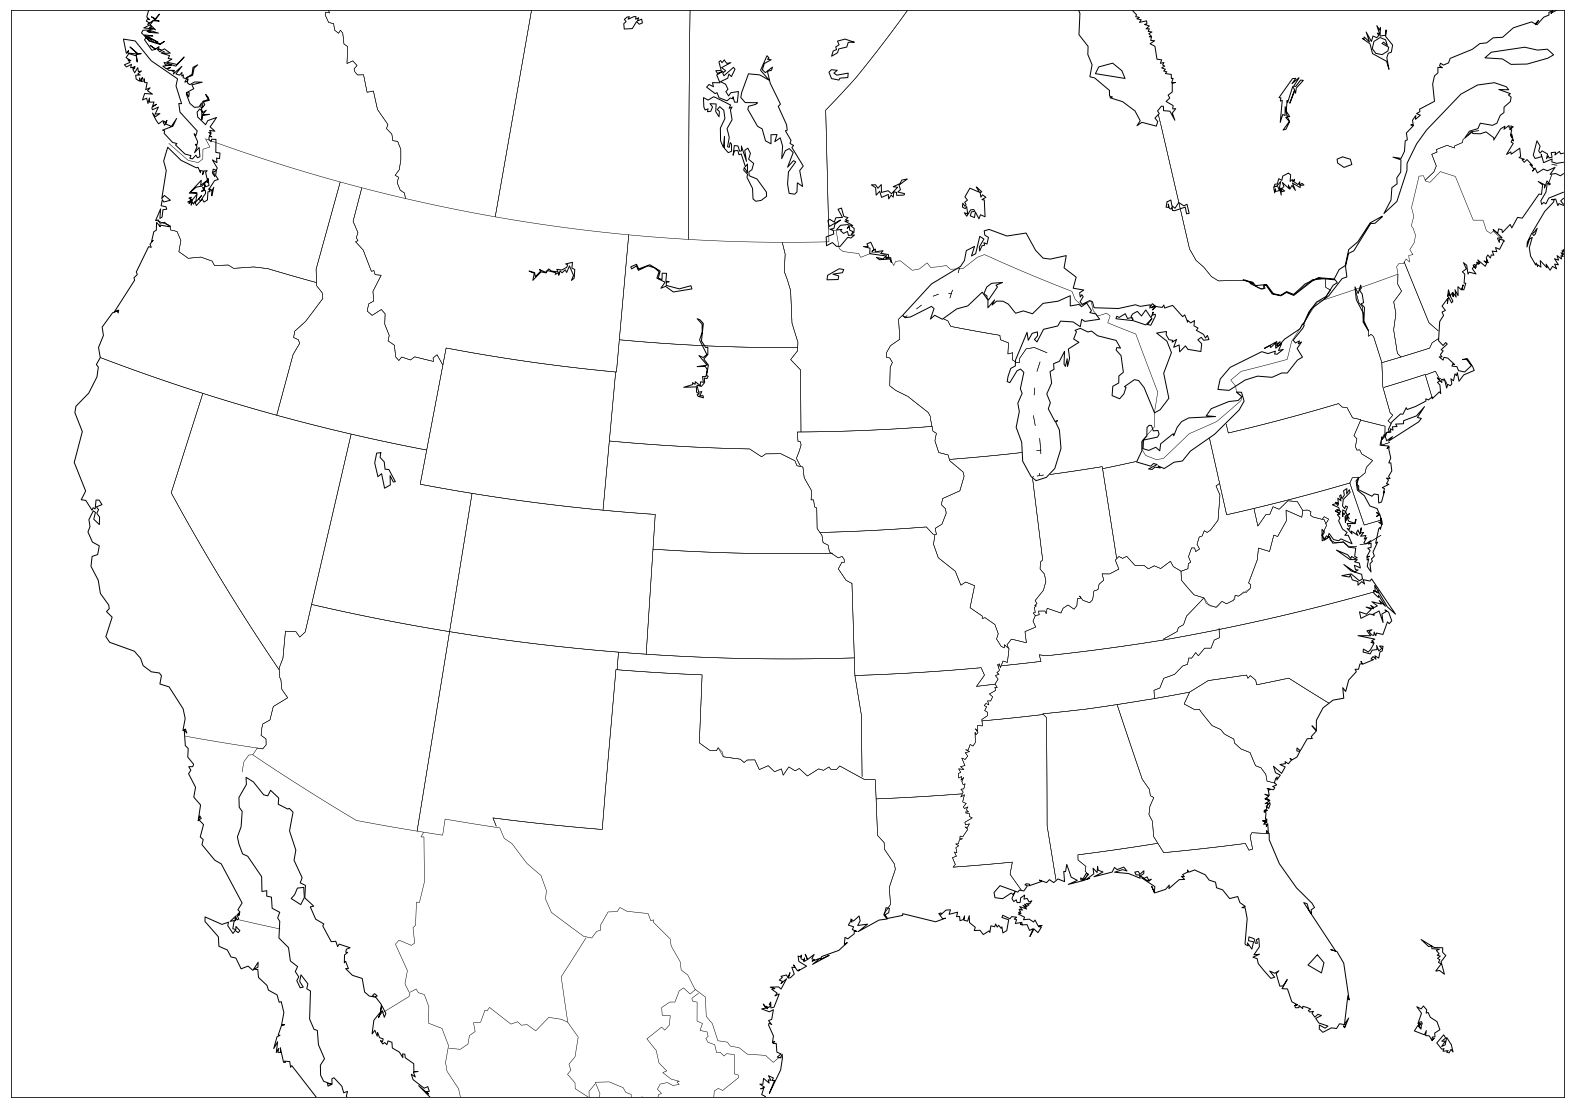

In [28]:
plt.figure(figsize=(30,20))
m = Basemap(width=5000000,height=3500000, projection='lcc', resolution='l',lat_1=45.,lat_2=55,lat_0=40,lon_0=-97.)
#m.shadedrelief()
m.drawcoastlines()
m.drawstates()
m.drawcountries()
    
x, y = m(list(data['longitude']), list(data['latitude']))


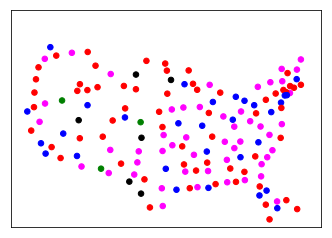

In [31]:
airspace_colors = {'B':'blue', 'D':'red', 'C':'magenta', 'E':'green', 'G': 'black'}
m.scatter(x,y, marker='o', c=data['airspace'].apply(lambda x:airspace_colors[x]), s=30)
plt.show()

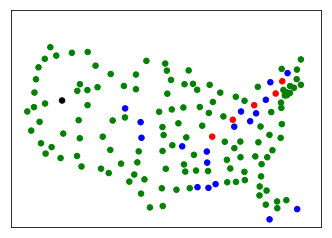

In [34]:
cat_colors = {'VFR':'green', 'MVFR':'blue', 'IFR':'red', 'LIFR':'magenta', None: 'black'}
m.scatter(x,y, marker='o', c=data['flight_category'].apply(lambda x:cat_colors[x]), s=30)
plt.show()